Using LSTMs to Predict the Output of Chemical Simulation under Uncertainty

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import norm
from tqdm import tqdm
from base import TrainingConfig, BaseModel, CNNConfig, LSTMConfig
from models import *
from Bioprocess_Sim import *
from CSTR_Sim import *
from utils import *
from tqdm.notebook import tqdm
np.random.seed(42)

#### Create the Simulation Environment - for a CSTR

3 State Variables:
$$
C_A, \, T, \, \text{Concentration of A, Temperature and Setpoint}, C_{As}
$$

2 Manipulated Variables:
$$
T_i, \, C_{Af} \, \text{Inlet Temperature and Feed Concentration}
$$

Disturbance: 
$$
T_C, \text{ - coolant temperature}
$$

The Simulation randomly generates actions, setpoints and disturbances across the length of the simulation, with the aim of the data driven model being to learn the relationships between variables to predict the temporal value of the state variables (exc setpoint) within a confidence interval

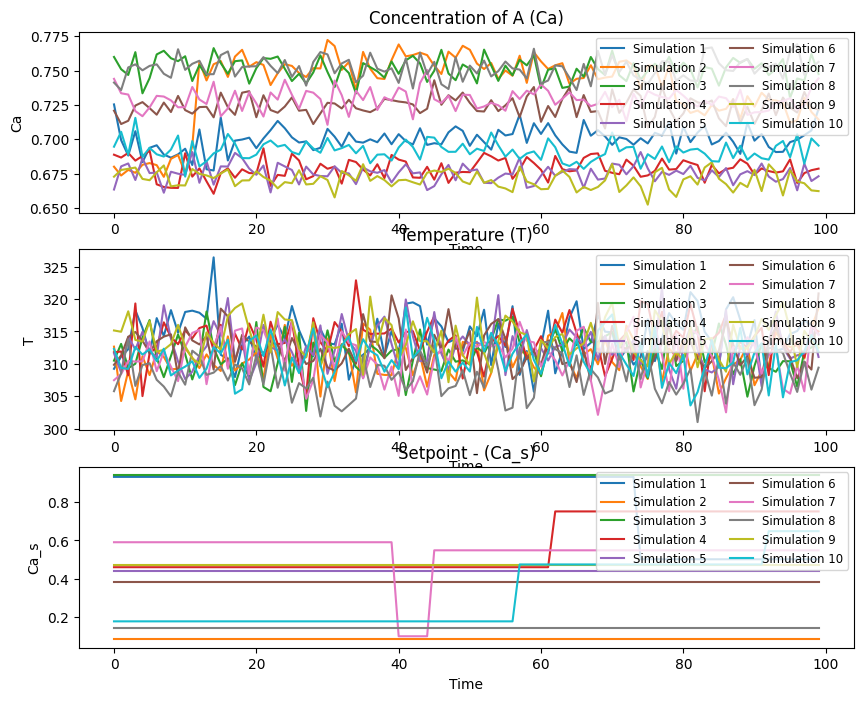

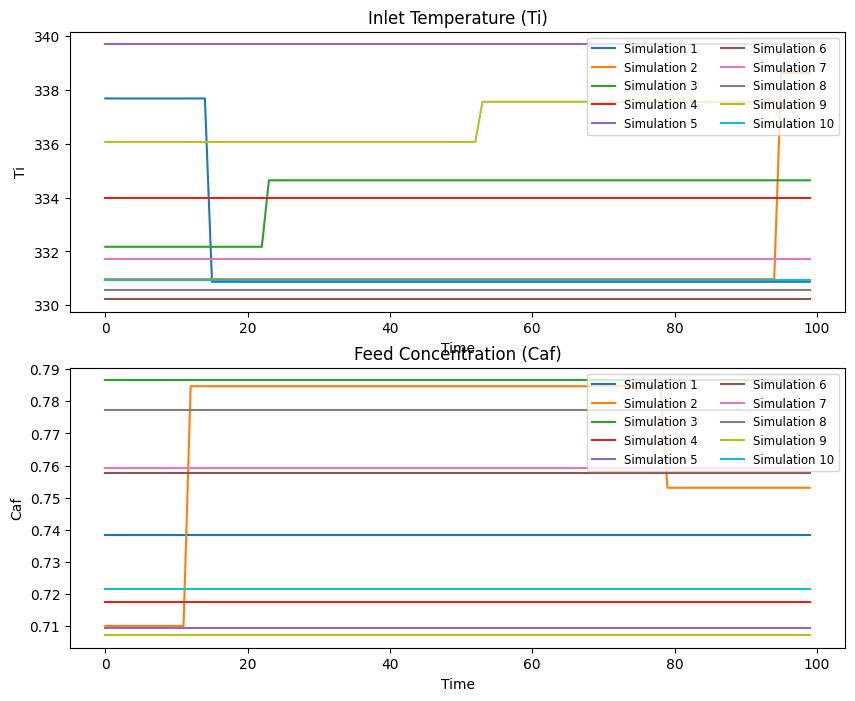

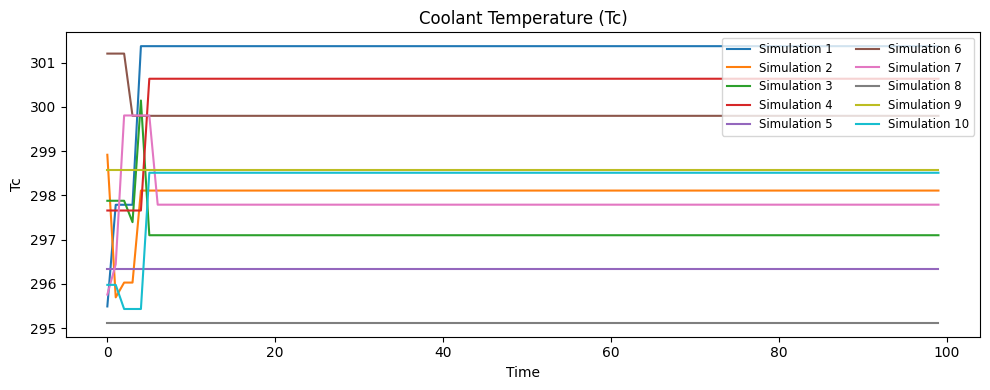

In [2]:
CSTR_Config = SimulationConfig(n_simulations=10, T = 101, tsim = 500) # Simulate the CSTR 10 times, with 5000 timesteps over 1000 second period

simulator = CSTRSimulator(CSTR_Config)
simulation_results = simulator.run_multiple_simulations()

# Plot the output of the Simulation
simulator.plot_results(simulation_results)

Then process the simulation output into data to be fed into the data driven model. First define a training configuration.

The data is processed into sequences with a lookback window and a prediction horizon of shape (time_step, lookback_window, no_features).

The data is then scaled using a MinMaxScaler, and split into a sequential train test set with the first 80% of the datapoints being included in the train set.


In [3]:
converter = CSTRConverter()
features, targets = converter.convert(simulation_results)

# Define a preliminary training configuration for the model
# Data processing uses an initial lookback region of 5 timesteps to predict 1 in the future 
# with an 80% train test split and a batch size of 4
training_config = TrainingConfig(
    batch_size = 4,
    num_epochs = 50,
    learning_rate = 0.001,
    time_step = 5,
    horizon = 1,
    weight_decay = 0.01,
    factor = 0.8,
    patience = 10,
    delta = 0.1,
    train_test_split = 0.8,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
)

data_processor = DataProcessor(training_config)
(train_loader, test_loader, X_train, X_test, y_train, y_test) = data_processor.prepare_data(features, targets)

Can then train an initial model, in this example use a unidirectional point prediction LSTM, defining the configuration for the model.

In [4]:
LSTM_Config = LSTMConfig(
    hidden_dim = 64,
    num_layers=2,
    dropout = 0.2,
    bidirectional=False,
)

quantiles = [0.25, 0.5, 0.75]

model = StandardLSTM(
    config = LSTM_Config,
    input_dim = X_train.shape[2],
    output_dim = y_train.shape[1],
)

# Train the model
criterion = nn.MSELoss()
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

Epoch [10/50], Train Loss: 0.0412, Test Loss: 0.0419, Avg Loss: 0.0416
Epoch [20/50], Train Loss: 0.0412, Test Loss: 0.0424, Avg Loss: 0.0418
Epoch [30/50], Train Loss: 0.0412, Test Loss: 0.0423, Avg Loss: 0.0418
Epoch [40/50], Train Loss: 0.0410, Test Loss: 0.0421, Avg Loss: 0.0415
Epoch [50/50], Train Loss: 0.0412, Test Loss: 0.0424, Avg Loss: 0.0418


Evaluate the model and inverse transform the data to plot and visualise the model predictions against the ground truth.

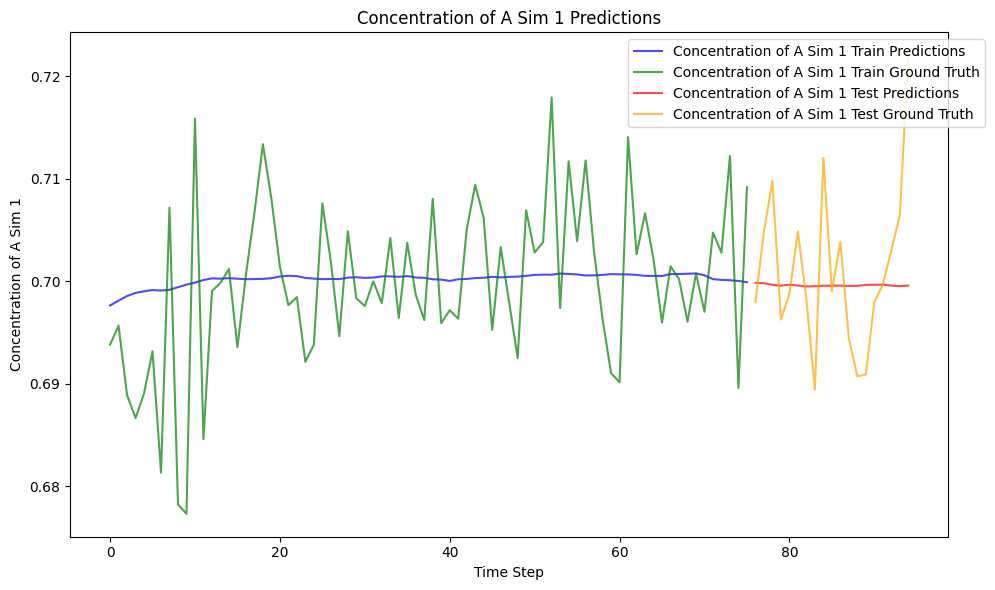

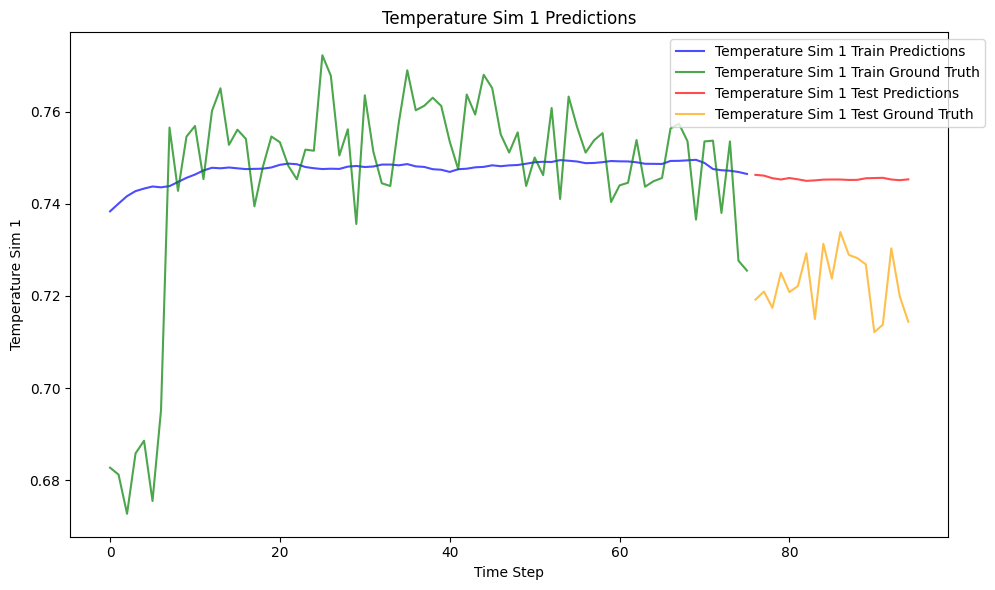

In [5]:
# Find the model predictions
model.eval()
with torch.no_grad():
    train_pred = model(X_train.to(training_config.device)).cpu().numpy()
    test_pred = model(X_test.to(training_config.device)).cpu().numpy()

# Transform the predictions back to the original
scaler = data_processor.target_scaler
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Invert the ground truth data
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)


# Plot the results of the model
feature_names = ['Concentration of A', 'Temperature']
visualiser = Visualizer()
# For simplicity we will plot the first simulation
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=1)
    

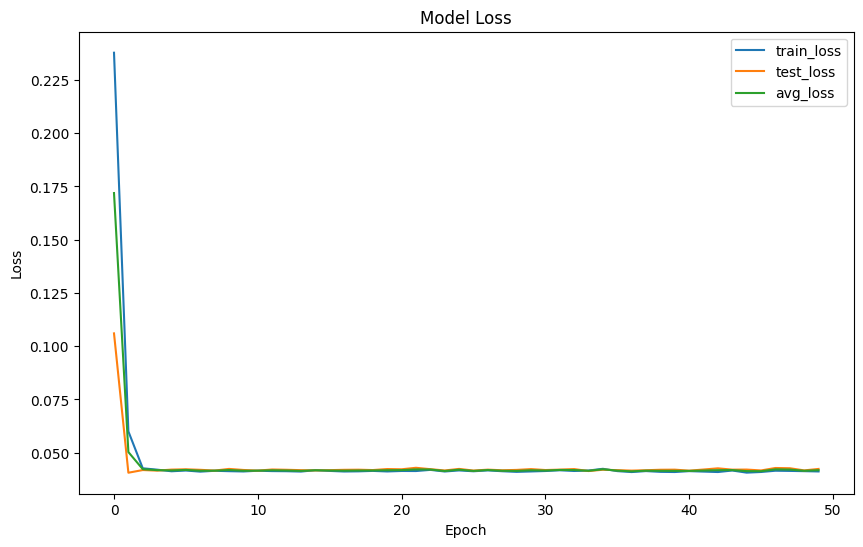

In [6]:
# Plot the loss of the model
visualiser.plot_loss(history)

Can use Bayesian Optimisation to find the best hyperparameters for the model

In [8]:
# First set the bounds for LSTM Model
LSTM_ConfigBounds = {
        'batch_size': (2, 50) if isinstance(simulator, CSTRSimulator) else (2, 10),
        'num_epochs': (50, 200),
        'learning_rate': (0.0001, 0.1),
        'time_step': (2, 50) if isinstance(simulator, CSTRSimulator) else (2, 10),
        'horizon': (1, 10),
        'weight_decay': (1e-6, 0.1),
        'factor': (0.1, 0.99),
        'patience': (5, 100),
        'delta': (1e-6, 0.1),   
        
        # LSTM specific bounds
        'hidden_dim': (32, 256),
        'num_layers': (1, 15),
        'dropout': (0.1, 0.9),
        'bidirectional': (0, 1),
        'use_batch_norm': (0, 1),
    
}

# Call the optimiser
optimiser = ModelOptimisation(model_class=StandardLSTM, sim_config=CSTR_Config,
                              train_config=training_config, model_config=LSTM_Config,
                              config_bounds=LSTM_ConfigBounds, simulator=CSTRSimulator,
                              converter=CSTRConverter, data_processor=DataProcessor,
                              trainer_class=ModelTrainer, iters=20)

best_params, best_loss = optimiser.optimise()
# The best performing model is saved automatically by the optimiser and can be loaded
cp = torch.load('best_model.pth')
model = StandardLSTM(cp['model_config'],
                     input_dim=X_train.shape[2],
                     output_dim=y_train.shape[1],
                     )
model.load_state_dict(cp['model_state_dict'])

Epoch [10/160], Train Loss: 0.0463, Test Loss: 0.0444, Avg Loss: 0.0453
Epoch [20/160], Train Loss: 0.0443, Test Loss: 0.0426, Avg Loss: 0.0434
Epoch [30/160], Train Loss: 0.0453, Test Loss: 0.0448, Avg Loss: 0.0450
Epoch [40/160], Train Loss: 0.0454, Test Loss: 0.0448, Avg Loss: 0.0451
Epoch [50/160], Train Loss: 0.0451, Test Loss: 0.0447, Avg Loss: 0.0449
Epoch [60/160], Train Loss: 0.0441, Test Loss: 0.0448, Avg Loss: 0.0445
Epoch [70/160], Train Loss: 0.0456, Test Loss: 0.0448, Avg Loss: 0.0452
Epoch [80/160], Train Loss: 0.0450, Test Loss: 0.0448, Avg Loss: 0.0449
Early Stopping
Epoch [10/98], Train Loss: 0.0490, Test Loss: 0.0532, Avg Loss: 0.0511
Epoch [20/98], Train Loss: 0.0427, Test Loss: 0.0514, Avg Loss: 0.0470
Epoch [30/98], Train Loss: 0.0414, Test Loss: 0.0528, Avg Loss: 0.0471
Epoch [40/98], Train Loss: 0.0405, Test Loss: 0.0467, Avg Loss: 0.0436
Epoch [50/98], Train Loss: 0.0388, Test Loss: 0.0480, Avg Loss: 0.0434
Epoch [60/98], Train Loss: 0.0391, Test Loss: 0.0499, 

Optimisation Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/91], Train Loss: 0.0468, Test Loss: 0.0589, Avg Loss: 0.0529
Epoch [20/91], Train Loss: 0.0490, Test Loss: 0.0542, Avg Loss: 0.0516
Epoch [30/91], Train Loss: 0.0489, Test Loss: 0.0536, Avg Loss: 0.0512
Epoch [40/91], Train Loss: 0.0483, Test Loss: 0.0549, Avg Loss: 0.0516
Epoch [50/91], Train Loss: 0.0513, Test Loss: 0.0543, Avg Loss: 0.0528
Epoch [60/91], Train Loss: 0.0494, Test Loss: 0.0564, Avg Loss: 0.0529
Epoch [70/91], Train Loss: 0.0487, Test Loss: 0.0556, Avg Loss: 0.0522
Epoch [80/91], Train Loss: 0.0494, Test Loss: 0.0525, Avg Loss: 0.0509
Epoch [90/91], Train Loss: 0.0493, Test Loss: 0.0559, Avg Loss: 0.0526


Optimisation Progress:   5%|▌         | 1/20 [00:19<06:17, 19.85s/it, Loss=0.0429]

Epoch [10/144], Train Loss: 0.0487, Test Loss: 0.0488, Avg Loss: 0.0487
Epoch [20/144], Train Loss: 0.0486, Test Loss: 0.0560, Avg Loss: 0.0523
Epoch [30/144], Train Loss: 0.0425, Test Loss: 0.0657, Avg Loss: 0.0541
Epoch [40/144], Train Loss: 0.0436, Test Loss: 0.0574, Avg Loss: 0.0505
Epoch [50/144], Train Loss: 0.0492, Test Loss: 0.0572, Avg Loss: 0.0532
Epoch [60/144], Train Loss: 0.0419, Test Loss: 0.0537, Avg Loss: 0.0478
Epoch [70/144], Train Loss: 0.0432, Test Loss: 0.0582, Avg Loss: 0.0507
Epoch [80/144], Train Loss: 0.0411, Test Loss: 0.0602, Avg Loss: 0.0507
Epoch [90/144], Train Loss: 0.0436, Test Loss: 0.0563, Avg Loss: 0.0500
Epoch [100/144], Train Loss: 0.0430, Test Loss: 0.0556, Avg Loss: 0.0493
Epoch [110/144], Train Loss: 0.0439, Test Loss: 0.0576, Avg Loss: 0.0508
Epoch [120/144], Train Loss: 0.0444, Test Loss: 0.0558, Avg Loss: 0.0501
Epoch [130/144], Train Loss: 0.0437, Test Loss: 0.0562, Avg Loss: 0.0500
Epoch [140/144], Train Loss: 0.0425, Test Loss: 0.0555, Avg 

Optimisation Progress:  10%|█         | 2/20 [00:29<04:13, 14.06s/it, Loss=0.0429]

Epoch [10/79], Train Loss: 0.0461, Test Loss: 0.0473, Avg Loss: 0.0467
Epoch [20/79], Train Loss: 0.0460, Test Loss: 0.0649, Avg Loss: 0.0555
Epoch [30/79], Train Loss: 0.0448, Test Loss: 0.0605, Avg Loss: 0.0526
Epoch [40/79], Train Loss: 0.0457, Test Loss: 0.0486, Avg Loss: 0.0472
Epoch [50/79], Train Loss: 0.0447, Test Loss: 0.0540, Avg Loss: 0.0493
Epoch [60/79], Train Loss: 0.0429, Test Loss: 0.0566, Avg Loss: 0.0497
Epoch [70/79], Train Loss: 0.0454, Test Loss: 0.0583, Avg Loss: 0.0519


Optimisation Progress:  15%|█▌        | 3/20 [03:39<26:42, 94.26s/it, Loss=0.0429]

Epoch [10/141], Train Loss: 1.2090, Test Loss: 0.0901, Avg Loss: 0.6495
Epoch [20/141], Train Loss: 2.1712, Test Loss: 0.4452, Avg Loss: 1.3082
Epoch [30/141], Train Loss: 2.1076, Test Loss: 1.3200, Avg Loss: 1.7138
Epoch [40/141], Train Loss: 2.4313, Test Loss: 1.0665, Avg Loss: 1.7489
Epoch [50/141], Train Loss: 2.0749, Test Loss: 1.6258, Avg Loss: 1.8504
Epoch [60/141], Train Loss: 1.6894, Test Loss: 1.0548, Avg Loss: 1.3721
Epoch [70/141], Train Loss: 1.5097, Test Loss: 1.9013, Avg Loss: 1.7055
Epoch [80/141], Train Loss: 1.6772, Test Loss: 1.6652, Avg Loss: 1.6712
Epoch [90/141], Train Loss: 2.0463, Test Loss: 1.3088, Avg Loss: 1.6775
Epoch [100/141], Train Loss: 1.8550, Test Loss: 1.1633, Avg Loss: 1.5091
Epoch [110/141], Train Loss: 3.2127, Test Loss: 2.6775, Avg Loss: 2.9451
Epoch [120/141], Train Loss: 2.8810, Test Loss: 2.6487, Avg Loss: 2.7649
Epoch [130/141], Train Loss: 3.3640, Test Loss: 3.1719, Avg Loss: 3.2679
Epoch [140/141], Train Loss: 3.8162, Test Loss: 4.1270, Avg 

Optimisation Progress:  20%|██        | 4/20 [05:24<26:16, 98.53s/it, Loss=0.0429]

Epoch [10/142], Train Loss: 0.6473, Test Loss: 0.0612, Avg Loss: 0.3543
Epoch [20/142], Train Loss: 0.0452, Test Loss: 0.0594, Avg Loss: 0.0523
Epoch [30/142], Train Loss: 0.0416, Test Loss: 0.0542, Avg Loss: 0.0479
Epoch [40/142], Train Loss: 0.0429, Test Loss: 0.0561, Avg Loss: 0.0495
Epoch [50/142], Train Loss: 0.0391, Test Loss: 0.0547, Avg Loss: 0.0469
Epoch [60/142], Train Loss: 0.0406, Test Loss: 0.0525, Avg Loss: 0.0465
Epoch [70/142], Train Loss: 0.0401, Test Loss: 0.0555, Avg Loss: 0.0478
Epoch [80/142], Train Loss: 0.0386, Test Loss: 0.0545, Avg Loss: 0.0466
Epoch [90/142], Train Loss: 0.0442, Test Loss: 0.0533, Avg Loss: 0.0488
Epoch [100/142], Train Loss: 0.0411, Test Loss: 0.0561, Avg Loss: 0.0486
Epoch [110/142], Train Loss: 0.0468, Test Loss: 0.0608, Avg Loss: 0.0538
Epoch [120/142], Train Loss: 0.0431, Test Loss: 0.0545, Avg Loss: 0.0488
Epoch [130/142], Train Loss: 0.0432, Test Loss: 0.0537, Avg Loss: 0.0484
Epoch [140/142], Train Loss: 0.0397, Test Loss: 0.0538, Avg 

Optimisation Progress:  25%|██▌       | 5/20 [06:50<23:27, 93.85s/it, Loss=0.0429]

Epoch [10/137], Train Loss: 2.8731, Test Loss: 1.7977, Avg Loss: 2.3354
Epoch [20/137], Train Loss: 0.4720, Test Loss: 0.1113, Avg Loss: 0.2917
Epoch [30/137], Train Loss: 0.2212, Test Loss: 0.0688, Avg Loss: 0.1450
Epoch [40/137], Train Loss: 0.1374, Test Loss: 0.1334, Avg Loss: 0.1354
Epoch [50/137], Train Loss: 0.0663, Test Loss: 0.0593, Avg Loss: 0.0628
Epoch [60/137], Train Loss: 0.0697, Test Loss: 0.0536, Avg Loss: 0.0616
Epoch [70/137], Train Loss: 0.0526, Test Loss: 0.0501, Avg Loss: 0.0514
Epoch [80/137], Train Loss: 0.0464, Test Loss: 0.0432, Avg Loss: 0.0448
Epoch [90/137], Train Loss: 0.0435, Test Loss: 0.0432, Avg Loss: 0.0433
Epoch [100/137], Train Loss: 0.0402, Test Loss: 0.0439, Avg Loss: 0.0420
Epoch [110/137], Train Loss: 0.0398, Test Loss: 0.0435, Avg Loss: 0.0416
Epoch [120/137], Train Loss: 0.0399, Test Loss: 0.0458, Avg Loss: 0.0429
Epoch [130/137], Train Loss: 0.0407, Test Loss: 0.0445, Avg Loss: 0.0426


Optimisation Progress:  30%|███       | 6/20 [08:23<21:51, 93.65s/it, Loss=0.0414]

Epoch [10/81], Train Loss: 0.0521, Test Loss: 0.0561, Avg Loss: 0.0541
Epoch [20/81], Train Loss: 0.0494, Test Loss: 0.0506, Avg Loss: 0.0500
Epoch [30/81], Train Loss: 0.0493, Test Loss: 0.0559, Avg Loss: 0.0526
Epoch [40/81], Train Loss: 0.0472, Test Loss: 0.0610, Avg Loss: 0.0541
Epoch [50/81], Train Loss: 0.0502, Test Loss: 0.0529, Avg Loss: 0.0516
Epoch [60/81], Train Loss: 0.0508, Test Loss: 0.0508, Avg Loss: 0.0508
Epoch [70/81], Train Loss: 0.0481, Test Loss: 0.0564, Avg Loss: 0.0522
Epoch [80/81], Train Loss: 0.0481, Test Loss: 0.0547, Avg Loss: 0.0514


Optimisation Progress:  35%|███▌      | 7/20 [08:53<15:48, 72.97s/it, Loss=0.0414]

Epoch [10/83], Train Loss: 0.0627, Test Loss: 0.0716, Avg Loss: 0.0672
Epoch [20/83], Train Loss: 0.0356, Test Loss: 0.0433, Avg Loss: 0.0395
Epoch [30/83], Train Loss: 0.0363, Test Loss: 0.0415, Avg Loss: 0.0389
Epoch [40/83], Train Loss: 0.0367, Test Loss: 0.0414, Avg Loss: 0.0391
Epoch [50/83], Train Loss: 0.0343, Test Loss: 0.0415, Avg Loss: 0.0379
Epoch [60/83], Train Loss: 0.0338, Test Loss: 0.0410, Avg Loss: 0.0374


Optimisation Progress:  40%|████      | 8/20 [08:55<10:03, 50.30s/it, Loss=0.0385]

Epoch [70/83], Train Loss: 0.0358, Test Loss: 0.0406, Avg Loss: 0.0382
Epoch [80/83], Train Loss: 0.0351, Test Loss: 0.0412, Avg Loss: 0.0381
Epoch [10/78], Train Loss: 0.1946, Test Loss: 0.1690, Avg Loss: 0.1818
Epoch [20/78], Train Loss: 0.0397, Test Loss: 0.0341, Avg Loss: 0.0369
Epoch [30/78], Train Loss: 0.0383, Test Loss: 0.0335, Avg Loss: 0.0359
Epoch [40/78], Train Loss: 0.0376, Test Loss: 0.0333, Avg Loss: 0.0355
Epoch [50/78], Train Loss: 0.0377, Test Loss: 0.0330, Avg Loss: 0.0353
Epoch [60/78], Train Loss: 0.0371, Test Loss: 0.0328, Avg Loss: 0.0350
Epoch [70/78], Train Loss: 0.0381, Test Loss: 0.0331, Avg Loss: 0.0356


Optimisation Progress:  45%|████▌     | 9/20 [09:39<08:51, 48.30s/it, Loss=0.0349]

Epoch [10/86], Train Loss: 0.2774, Test Loss: 0.2759, Avg Loss: 0.2767
Epoch [20/86], Train Loss: 0.2677, Test Loss: 0.2641, Avg Loss: 0.2659
Epoch [30/86], Train Loss: 0.2544, Test Loss: 0.2535, Avg Loss: 0.2539
Epoch [40/86], Train Loss: 0.2412, Test Loss: 0.2428, Avg Loss: 0.2420
Epoch [50/86], Train Loss: 0.2283, Test Loss: 0.2318, Avg Loss: 0.2300
Epoch [60/86], Train Loss: 0.2288, Test Loss: 0.2200, Avg Loss: 0.2244
Epoch [70/86], Train Loss: 0.2044, Test Loss: 0.2069, Avg Loss: 0.2057
Epoch [80/86], Train Loss: 0.1971, Test Loss: 0.1929, Avg Loss: 0.1950


Optimisation Progress:  50%|█████     | 10/20 [10:32<08:17, 49.73s/it, Loss=0.0349]

Epoch [10/189], Train Loss: 0.0567, Test Loss: 0.0709, Avg Loss: 0.0638
Epoch [20/189], Train Loss: 0.0569, Test Loss: 0.0591, Avg Loss: 0.0580
Epoch [30/189], Train Loss: 0.0566, Test Loss: 0.0633, Avg Loss: 0.0600
Epoch [40/189], Train Loss: 0.0589, Test Loss: 0.0611, Avg Loss: 0.0600
Epoch [50/189], Train Loss: 0.0575, Test Loss: 0.0595, Avg Loss: 0.0585
Epoch [60/189], Train Loss: 0.0578, Test Loss: 0.0585, Avg Loss: 0.0582
Epoch [70/189], Train Loss: 0.0574, Test Loss: 0.0596, Avg Loss: 0.0585
Epoch [80/189], Train Loss: 0.0595, Test Loss: 0.0621, Avg Loss: 0.0608
Epoch [90/189], Train Loss: 0.0568, Test Loss: 0.0669, Avg Loss: 0.0618
Epoch [100/189], Train Loss: 0.0581, Test Loss: 0.0604, Avg Loss: 0.0592
Epoch [110/189], Train Loss: 0.0565, Test Loss: 0.0599, Avg Loss: 0.0582
Epoch [120/189], Train Loss: 0.0590, Test Loss: 0.0582, Avg Loss: 0.0586
Epoch [130/189], Train Loss: 0.0567, Test Loss: 0.0553, Avg Loss: 0.0560
Epoch [140/189], Train Loss: 0.0583, Test Loss: 0.0594, Avg 

Optimisation Progress:  55%|█████▌    | 11/20 [10:37<05:25, 36.15s/it, Loss=0.0349]

Epoch [10/70], Train Loss: 19.1055, Test Loss: 10.1791, Avg Loss: 14.6423
Epoch [20/70], Train Loss: 27.9424, Test Loss: 21.3085, Avg Loss: 24.6254
Epoch [30/70], Train Loss: 30.2476, Test Loss: 14.2159, Avg Loss: 22.2318
Epoch [40/70], Train Loss: 19.0169, Test Loss: 22.7211, Avg Loss: 20.8690
Epoch [50/70], Train Loss: 19.1592, Test Loss: 24.7736, Avg Loss: 21.9664
Epoch [60/70], Train Loss: 27.3115, Test Loss: 20.8957, Avg Loss: 24.1036


Optimisation Progress:  60%|██████    | 12/20 [12:03<06:49, 51.13s/it, Loss=0.0349]

Epoch [70/70], Train Loss: 19.5861, Test Loss: 14.0226, Avg Loss: 16.8043
Epoch [10/87], Train Loss: 0.2357, Test Loss: 0.2653, Avg Loss: 0.2505
Epoch [20/87], Train Loss: 0.1779, Test Loss: 0.2017, Avg Loss: 0.1898
Epoch [30/87], Train Loss: 0.0817, Test Loss: 0.0919, Avg Loss: 0.0868
Epoch [40/87], Train Loss: 0.0471, Test Loss: 0.0510, Avg Loss: 0.0490
Epoch [50/87], Train Loss: 0.0420, Test Loss: 0.0490, Avg Loss: 0.0455
Epoch [60/87], Train Loss: 0.0415, Test Loss: 0.0486, Avg Loss: 0.0450
Epoch [70/87], Train Loss: 0.0399, Test Loss: 0.0479, Avg Loss: 0.0439
Epoch [80/87], Train Loss: 0.0408, Test Loss: 0.0477, Avg Loss: 0.0443


Optimisation Progress:  65%|██████▌   | 13/20 [12:37<05:22, 46.01s/it, Loss=0.0349]

Epoch [10/89], Train Loss: 0.3047, Test Loss: 0.2536, Avg Loss: 0.2792
Epoch [20/89], Train Loss: 0.2773, Test Loss: 0.2307, Avg Loss: 0.2540
Epoch [30/89], Train Loss: 0.2432, Test Loss: 0.2013, Avg Loss: 0.2222
Epoch [40/89], Train Loss: 0.1939, Test Loss: 0.1588, Avg Loss: 0.1763
Epoch [50/89], Train Loss: 0.1143, Test Loss: 0.0992, Avg Loss: 0.1068
Epoch [60/89], Train Loss: 0.0530, Test Loss: 0.0685, Avg Loss: 0.0607
Epoch [70/89], Train Loss: 0.0477, Test Loss: 0.0677, Avg Loss: 0.0577
Epoch [80/89], Train Loss: 0.0473, Test Loss: 0.0676, Avg Loss: 0.0574


Optimisation Progress:  70%|███████   | 14/20 [13:17<04:25, 44.17s/it, Loss=0.0349]

Epoch [10/87], Train Loss: 0.1008, Test Loss: 0.1000, Avg Loss: 0.1004
Epoch [20/87], Train Loss: 0.0406, Test Loss: 0.0521, Avg Loss: 0.0464
Epoch [30/87], Train Loss: 0.0395, Test Loss: 0.0515, Avg Loss: 0.0455
Epoch [40/87], Train Loss: 0.0390, Test Loss: 0.0512, Avg Loss: 0.0451
Epoch [50/87], Train Loss: 0.0388, Test Loss: 0.0511, Avg Loss: 0.0449
Epoch [60/87], Train Loss: 0.0385, Test Loss: 0.0508, Avg Loss: 0.0447
Epoch [70/87], Train Loss: 0.0384, Test Loss: 0.0506, Avg Loss: 0.0445
Epoch [80/87], Train Loss: 0.0384, Test Loss: 0.0506, Avg Loss: 0.0445


Optimisation Progress:  75%|███████▌  | 15/20 [13:22<02:41, 32.36s/it, Loss=0.0349]

Epoch [10/93], Train Loss: 0.1887, Test Loss: 0.1828, Avg Loss: 0.1858
Epoch [20/93], Train Loss: 0.0793, Test Loss: 0.0734, Avg Loss: 0.0763
Epoch [30/93], Train Loss: 0.0416, Test Loss: 0.0429, Avg Loss: 0.0423
Epoch [40/93], Train Loss: 0.0400, Test Loss: 0.0428, Avg Loss: 0.0414
Epoch [50/93], Train Loss: 0.0396, Test Loss: 0.0425, Avg Loss: 0.0411
Epoch [60/93], Train Loss: 0.0393, Test Loss: 0.0424, Avg Loss: 0.0408


Optimisation Progress:  80%|████████  | 16/20 [13:23<01:32, 23.11s/it, Loss=0.0349]

Epoch [70/93], Train Loss: 0.0389, Test Loss: 0.0424, Avg Loss: 0.0407
Epoch [80/93], Train Loss: 0.0386, Test Loss: 0.0423, Avg Loss: 0.0405
Epoch [90/93], Train Loss: 0.0383, Test Loss: 0.0423, Avg Loss: 0.0403
Epoch [10/81], Train Loss: 0.2456, Test Loss: 0.2723, Avg Loss: 0.2589
Epoch [20/81], Train Loss: 0.2232, Test Loss: 0.2486, Avg Loss: 0.2359
Epoch [30/81], Train Loss: 0.1977, Test Loss: 0.2214, Avg Loss: 0.2096
Epoch [40/81], Train Loss: 0.1659, Test Loss: 0.1869, Avg Loss: 0.1764
Epoch [50/81], Train Loss: 0.1247, Test Loss: 0.1421, Avg Loss: 0.1334
Epoch [60/81], Train Loss: 0.0787, Test Loss: 0.0924, Avg Loss: 0.0856
Epoch [70/81], Train Loss: 0.0529, Test Loss: 0.0651, Avg Loss: 0.0590
Epoch [80/81], Train Loss: 0.0476, Test Loss: 0.0592, Avg Loss: 0.0534


Optimisation Progress:  85%|████████▌ | 17/20 [13:47<01:09, 23.15s/it, Loss=0.0349]

Epoch [10/85], Train Loss: 0.2183, Test Loss: 0.2259, Avg Loss: 0.2221
Epoch [20/85], Train Loss: 0.1640, Test Loss: 0.1701, Avg Loss: 0.1670
Epoch [30/85], Train Loss: 0.1095, Test Loss: 0.1126, Avg Loss: 0.1110
Epoch [40/85], Train Loss: 0.0642, Test Loss: 0.0722, Avg Loss: 0.0682
Epoch [50/85], Train Loss: 0.0489, Test Loss: 0.0569, Avg Loss: 0.0529
Epoch [60/85], Train Loss: 0.0426, Test Loss: 0.0535, Avg Loss: 0.0480
Epoch [70/85], Train Loss: 0.0455, Test Loss: 0.0519, Avg Loss: 0.0487
Epoch [80/85], Train Loss: 0.0452, Test Loss: 0.0502, Avg Loss: 0.0477


Optimisation Progress:  90%|█████████ | 18/20 [13:49<00:33, 16.95s/it, Loss=0.0349]

Epoch [10/91], Train Loss: 0.0467, Test Loss: 0.0417, Avg Loss: 0.0442
Epoch [20/91], Train Loss: 0.0453, Test Loss: 0.0409, Avg Loss: 0.0431
Epoch [30/91], Train Loss: 0.0436, Test Loss: 0.0392, Avg Loss: 0.0414
Epoch [40/91], Train Loss: 0.0400, Test Loss: 0.0385, Avg Loss: 0.0392
Epoch [50/91], Train Loss: 0.0391, Test Loss: 0.0386, Avg Loss: 0.0388
Epoch [60/91], Train Loss: 0.0386, Test Loss: 0.0398, Avg Loss: 0.0392
Epoch [70/91], Train Loss: 0.0387, Test Loss: 0.0384, Avg Loss: 0.0385
Epoch [80/91], Train Loss: 0.0383, Test Loss: 0.0380, Avg Loss: 0.0382
Epoch [90/91], Train Loss: 0.0386, Test Loss: 0.0385, Avg Loss: 0.0386


Optimisation Progress:  95%|█████████▌| 19/20 [15:48<00:47, 47.40s/it, Loss=0.0349]

Epoch [10/74], Train Loss: 0.0490, Test Loss: 0.0440, Avg Loss: 0.0465
Epoch [20/74], Train Loss: 0.0369, Test Loss: 0.0418, Avg Loss: 0.0393
Epoch [30/74], Train Loss: 0.0362, Test Loss: 0.0413, Avg Loss: 0.0387
Epoch [40/74], Train Loss: 0.0364, Test Loss: 0.0416, Avg Loss: 0.0390
Epoch [50/74], Train Loss: 0.0363, Test Loss: 0.0412, Avg Loss: 0.0388
Epoch [60/74], Train Loss: 0.0358, Test Loss: 0.0413, Avg Loss: 0.0386
Epoch [70/74], Train Loss: 0.0361, Test Loss: 0.0408, Avg Loss: 0.0384


Optimisation Progress: 100%|██████████| 20/20 [17:02<00:00, 51.12s/it, Loss=0.0349]


({'batch_size': 6,
  'num_epochs': 78,
  'learning_rate': 0.0001,
  'time_step': 13,
  'horizon': 10,
  'weight_decay': 0.01376351279988987,
  'factor': 0.4526762754430208,
  'patience': 74,
  'delta': 0.04720121710909491,
  'hidden_dim': 181,
  'num_layers': 7,
  'dropout': 0.9,
  'bidirectional': 1,
  'use_batch_norm': 1},
 0.034947547214952385)

After optimising the model, load the data

In [ ]:
train_pred = model(X_train.to(training_config.device)).cpu().numpy()
test_pred = model(X_test.to(training_config.device)).cpu().numpy()

# Transform the predictions back to the original
train_pred, test_pred = scaler.inverse_transform(train_pred), scaler.inverse_transform(test_pred)
 
# Plot the optimised predictions of the model
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=1)

Can also use a second simulation, a Photoproduction Bioprocess Reactor.

This has state variables:
$C_x$ , biomass concentration in g/L

$C_N$ , nitrate concentration in mg/L

$C_{qc}$ , phycocyanin concentration in mg/L

The control variables are:
$I$, light intensity in $\mu  mol  m^{-2}  s^{-1}$

$F_N$, nitrate flow rate in $ mg. L^{-1} h{-1} $

In [ ]:
Bioprocess_Config = SimulationConfig(n_simulations=10, T = 101, tsim = 500) # Simulate the CSTR 10 times, with 5000 timesteps over 1000 second period

simulator = BioProcessSimulator(Bioprocess_Config)
simulation_results = simulator.run_multiple_simulations()

# Plot the output of the Simulation
simulator.plot_results(simulation_results)

In [10]:
converter = CSTRConverter()
features, targets = converter.convert(simulation_results)

# Define a preliminary training configuration for the model
# Data processing uses an initial lookback region of 5 timesteps to predict 1 in the future 
# with an 80% train test split and a batch size of 4
training_config = TrainingConfig(
    batch_size = 4,
    num_epochs = 50,
    learning_rate = 0.001,
    time_step = 5,
    horizon = 1,
    weight_decay = 0.01,
    factor = 0.8,
    patience = 10,
    delta = 0.1,
    train_test_split = 0.8,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
)

data_processor = DataProcessor(training_config)
(train_loader, test_loader, X_train, X_test, y_train, y_test) = data_processor.prepare_data(features, targets)

Epoch [10/74], Train Loss: 0.1549, Test Loss: 0.1307, Avg Loss: 0.1428
Epoch [20/74], Train Loss: 0.0507, Test Loss: 0.0483, Avg Loss: 0.0495
Epoch [30/74], Train Loss: 0.0464, Test Loss: 0.0455, Avg Loss: 0.0459
Epoch [40/74], Train Loss: 0.0444, Test Loss: 0.0444, Avg Loss: 0.0444
Epoch [50/74], Train Loss: 0.0439, Test Loss: 0.0437, Avg Loss: 0.0438
Epoch [60/74], Train Loss: 0.0431, Test Loss: 0.0431, Avg Loss: 0.0431
Epoch [70/74], Train Loss: 0.0432, Test Loss: 0.0429, Avg Loss: 0.0430


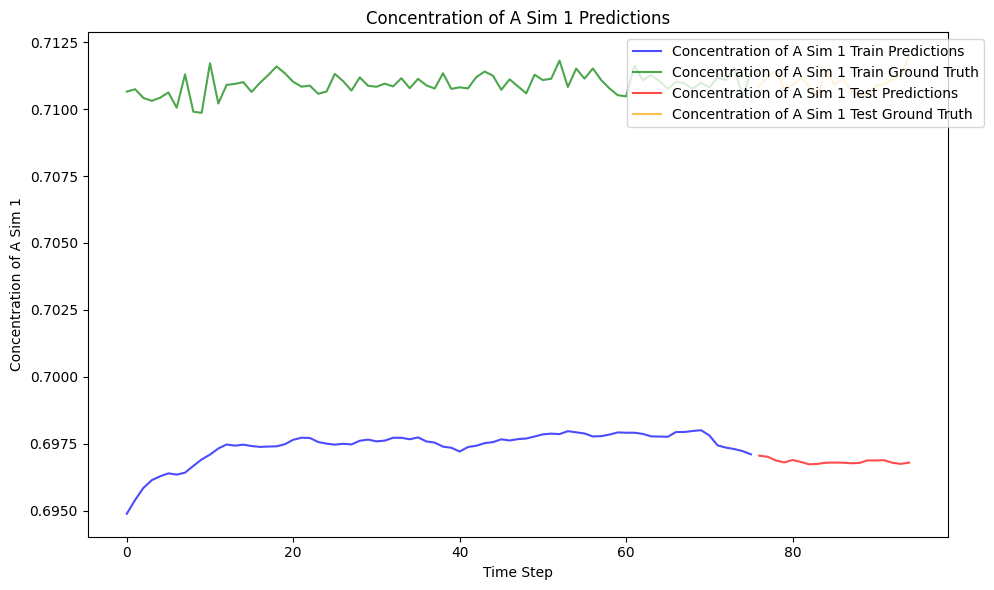

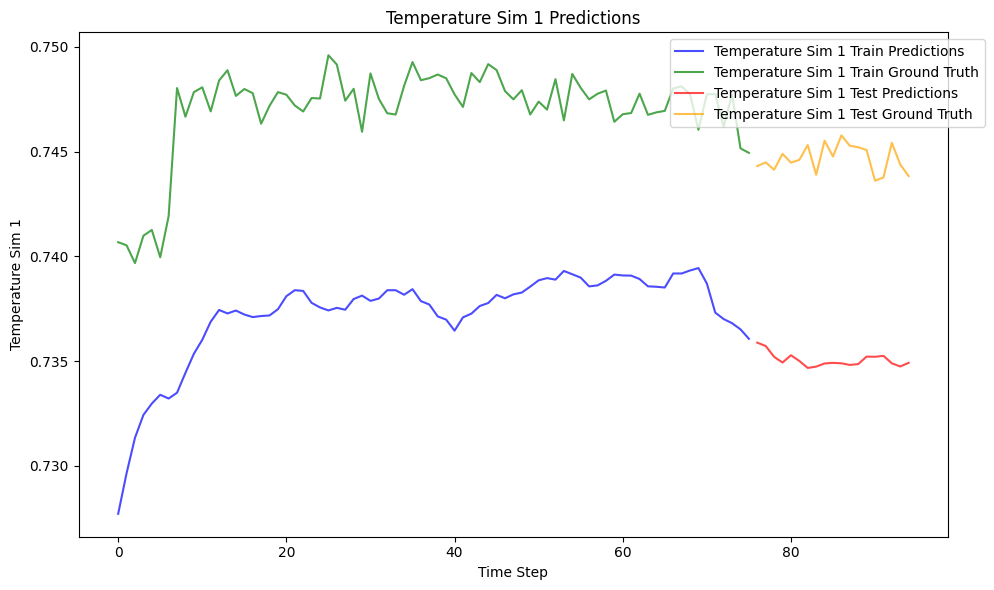

In [9]:
LSTM_Config = LSTMConfig(
    hidden_dim = 64,
    num_layers=2,
    dropout = 0.2,
    bidirectional=False,
)

quantiles = [0.25, 0.5, 0.75]

model = StandardLSTM(
    config = LSTM_Config,
    input_dim = X_train.shape[2],
    output_dim = y_train.shape[1],
)

# Train the model
criterion = nn.MSELoss()
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

# Find the model predictions
model.eval()
with torch.no_grad():
    train_pred = model(X_train.to(training_config.device)).cpu().numpy()
    test_pred = model(X_test.to(training_config.device)).cpu().numpy()

# Transform the predictions back to the original
scaler = data_processor.target_scaler
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Invert the ground truth data
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)


# Plot the results of the model
feature_names = ['Concentration of A', 'Temperature']
visualiser = Visualizer()
# For simplicity we will plot the first simulation
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=1)